# Optimization of Degree Distributions on the AWGN

This code is provided as supplementary material of the lecture Channel Coding 2 - Advanced Methods.

This code illustrates
* Using linear programming to optimize degree distributions on the AWGN channel using EXIT charts

In [4]:
import numpy as np
import matplotlib.pyplot as plot
from ipywidgets import interactive
import ipywidgets as widgets
import math
from pulp import *
%matplotlib inline  

Approximation of the J-function taken from [1] with
$$
J(\mu) \approx \left(1 - 2^{-H_1\cdot (2\mu)^{H_2}}\right)^{H_3}
$$
and its inverse function can be easily found as
$$
\mu = J^{-1}(I) \approx \frac{1}{2}\left(-\frac{1}{H_1}\log_2\left(1-I^{\frac{1}{H_3}}\right)\right)^{\frac{1}{H_2}}
$$
with $H_1 = 0.3073$, $H_2=0.8935$, and $H_3 = 1.1064$.

[1] F. Schreckenbach, _Iterative Decoding of Bit-Interleaved Coded Modulation_ , PhD thesis, TU Munich, 2007

In [59]:
H1 = 0.3073
H2 = 0.8935
H3 = 1.1064

def J_fun(mu):       
    I = (1 - 2**(-H1*(2*mu)**H2))**H3
    return I

def invJ_fun(I):
    if I > (1-1e-10):
        return 100
    mu = 0.5*(-(1/H1) * np.log2(1 - I**(1/H3)))**(1/H2)
    return mu

The following function solves the optimization problem that returns the best $\lambda(Z)$ for a given BI-AWGN channel quality $E_s/N_0$, corresponding to a $\mu_c = 4\frac{E_s}{N_0}$, for a regular check node degree $d_{\mathtt{c}}$, and for a maximum variable node degree $d_{\mathtt{v},\max}$. This optimization problem is derived in the lecture as
$$
\begin{aligned}
& \underset{\lambda_1,\ldots,\lambda_{d_{\mathtt{v},\max}}}{\text{maximize}} & & \sum_{i=1}^{d_{\mathtt{v},\max}}\frac{\lambda_i}{i} \\
& \text{subject to} & & \lambda_1 = 0 \\
& & & \lambda_i \geq 0, \quad \forall i \in\{2,3,\ldots,d_{\mathtt{v},\max}\} \\
& & & \sum_{i=2}^{d_{\mathtt{v},\max}}\lambda_i = 1 \\
& & & \sum_{i=2}^{d_{\mathtt{v},\max}}\lambda_i\cdot J\left(\mu_c + (i-1)J^{-1}\left(\frac{j}{D}\right)\right) > 1 - J\left(\frac{1}{d_{\mathtt{c}}-1}J^{-1}\left(1-\frac{j}{D}\right)\right),\quad  \forall j \in \{1,\ldots, D\} \\
& & & \lambda_2 \leq \frac{e^{\frac{\mu_c}{4}}}{d_{\mathtt{c}}-1}
\end{aligned}
$$

If this optimization problem is feasible, then the function returns the polynomial $\lambda(Z)$ as a coefficient array where the first entry corresponds to the largest exponent ($\lambda_{d_{\mathtt{v},\max}}$) and the last entry to the lowest exponent ($\lambda_1$). If the optimization problem has no solution (e.g., it is unfeasible), then the empty vector is returned.

In [85]:
def find_best_lambda(mu_c, v_max, dc):        
    # quantization of EXIT chart
    D = 500
    I_range = np.arange(0, D, 1)/D                    
    
    # Linear Programming model, maximize target expression
    model = pulp.LpProblem("Finding best lambda problem", pulp.LpMaximize)

    # definition of variables, v_max entries \lambda_i that are between 0 and 1 (implicit declaration of constraint 2)
    v_lambda = pulp.LpVariable.dicts("lambda", range(v_max),0,1)
    
    # objective function
    cv = 1/np.arange(v_max,0,-1)    
    model += pulp.lpSum(v_lambda[i]*cv[i] for i in range(v_max)) 
    
    # constraints
    # constraint 1, no variable nodes of degree 1
    model += v_lambda[v_max-1] == 0
    
    # constraint 3, sum of lambda_i must be 1
    model += pulp.lpSum(v_lambda[i] for i in range(v_max))==1
            
    # constraints 4, fixed point condition for all the descrete xi values  (a total number of D, for each \xi)  
    for myI in I_range:       
        model += pulp.lpSum(v_lambda[j] * J_fun(mu_c + (v_max-1-j)*invJ_fun(myI)) for j in range(v_max)) - 1 + J_fun(1/(dc-1)*invJ_fun(1-myI)) >= 0
    
    # constraint 5, stability condition
    model += v_lambda[v_max-2] <= np.exp(mu_c/4)/(dc-1)

    model.solve()
    if model.status != 1:
        r_lambda = []
    else:
        r_lambda = [v_lambda[i].varValue for i in range(v_max)]
    return r_lambda    

As an example, we consider the case of optimization carried out in the lecture after 10 iterations, where we have $\mu_c = 3.8086$ and $d_{\mathtt{c}} = 14$ with $d_{\mathtt{v},\max}=16$

In [86]:
best_lambda = find_best_lambda(3.8086, 16, 14)
print(np.poly1d(best_lambda, variable='Z'))

       15           6          5         2
0.335 Z  + 0.04282 Z + 0.1768 Z + 0.246 Z + 0.1993 Z


In the following, we provide an interactive widget that allows you to choose the parameters of the optimization yourself and get the best possible $\lambda(Z)$. Additionally, the EXIT chart is plotted to visualize the good fit of the obtained degree distribution.

In [88]:
def best_lambda_interactive(mu_c, v_max, dc):
    # get lambda and rho polynomial from optimization and from c_avg, respectively
    p_lambda = find_best_lambda(mu_c, v_max, dc)
        
    # if optimization successful, compute rate and show plot
    if not p_lambda:
        print('Optimization infeasible, no solution found')
    else:
        design_rate = 1 - 1/(dc * np.polyval(np.polyint(p_lambda),1))
        if design_rate <= 0:
            print('Optimization feasible, but no code with positive rate found')
        else:
            print("Lambda polynomial:")
            print(np.poly1d(p_lambda, variable='Z'))
            print("Design rate r_d = %1.3f" % design_rate)
            
            # Plot EXIT-Chart
            print("EXIT Chart:")
            plot.figure(3)    
            x = np.linspace(0, 1, num=100)
            y_v = [np.sum([p_lambda[j] * J_fun(mu_c + (v_max-1-j)*invJ_fun(xv)) for j in range(v_max)]) for xv in x]            
            y_c = [1-J_fun((dc-1)*invJ_fun(1-xv)) for xv in x]            
            plot.plot(x, y_v, '#7030A0')
            plot.plot(y_c, x, '#008000')            
            plot.axis('equal')
            plot.gca().set_aspect('equal', adjustable='box')
            plot.xlim(0,1)
            plot.ylim(0,1)        
            plot.grid()
            plot.show()

interactive_plot = interactive(best_lambda_interactive, \
                               mu_c=widgets.FloatSlider(min=0.5,max=8,step=0.01,value=3, continuous_update=False, description=r'\(\mu_c\)',layout=widgets.Layout(width='50%')), \
                               v_max = widgets.IntSlider(min=3, max=20, step=1, value=16, continuous_update=False, description=r'\(d_{\mathtt{v},\max}\)'), \
                               dc = widgets.IntSlider(min=3,max=20,step=1,value=4, continuous_update=False, description=r'\(d_{\mathtt{c}}\)'))                              
output = interactive_plot.children[-1]
output.layout.height = '400px'
interactive_plot

interactive(children=(FloatSlider(value=3.0, continuous_update=False, description='\\(\\mu_c\\)', layout=Layou…

Now, we carry out the optimization over a wide range of $d_{\mathtt{c},\text{avg}}$ values for a given $\epsilon$ and find the largest possible rate.

In [118]:
def find_best_rate(mu_c, dv_max, dc_max):
    c_range = np.arange(3, dc_max+1)
    rates = np.zeros_like(c_range,dtype=float)
    
    
    # loop over all c_avg, add progress bar
    f = widgets.FloatProgress(min=0, max=np.size(c_range))
    display(f)
    for index,dc in enumerate(c_range):
        f.value += 1        
        p_lambda = find_best_lambda(mu_c, dv_max, dc)                
        if p_lambda:            
            design_rate = 1 - 1/(dc * np.polyval(np.polyint(p_lambda),1))
            if design_rate >= 0:
                rates[index] = design_rate
    
    # find largest rate
    largest_rate_index = np.argmax(rates)
    best_lambda = find_best_lambda(mu_c, dv_max, c_range[largest_rate_index])
    print("Found best code of rate %1.3f for average check node degree of %1.2f" % (rates[largest_rate_index], c_range[largest_rate_index]))
    print("Corresponding lambda polynomial")
    print(np.poly1d(best_lambda, variable='Z'))
    
    # Plot curve with all obtained results
    plot.figure(4, figsize=(10,3))    
    plot.plot(c_range, rates, 'b--s',color=(0, 0.59, 0.51))
    plot.plot(c_range[largest_rate_index], rates[largest_rate_index], 'rs')
    plot.xlim(3, dc_max)
    plot.xticks(range(3,dc_max+1))
    plot.ylim(0, 1)
    plot.xlabel('$d_{\mathtt{c}}$')
    plot.ylabel('design rate $r_d$')
    plot.grid()
    plot.show()

    return rates[largest_rate_index]
    
interactive_optim = interactive(find_best_rate, \
                               mu_c=widgets.FloatSlider(min=0.1,max=10,step=0.01,value=2, continuous_update=False, description=r'\(\mu_c\)',layout=widgets.Layout(width='50%')), \
                               dv_max = widgets.IntSlider(min=3, max=20, step=1, value=16, continuous_update=False, description=r'\(d_{\mathtt{v},\max}\)'), \
                               dc_max = widgets.IntSlider(min=3, max=40, step=1, value=22, continuous_update=False, description=r'\(d_{\mathtt{c},\max}\)'))
output = interactive_optim.children[-1]
output.layout.height = '400px'
interactive_optim

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='\\(\\mu_c\\)', layout=Layou…

Running binary search to find code with a given target rate for the AWGN channel

Running optimization for mu_c = 10.00000, corresponding to Es/N0 = 3.98 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.894 for average check node degree of 22.00
Corresponding lambda polynomial
        2
0.4199 Z + 0.5801 Z


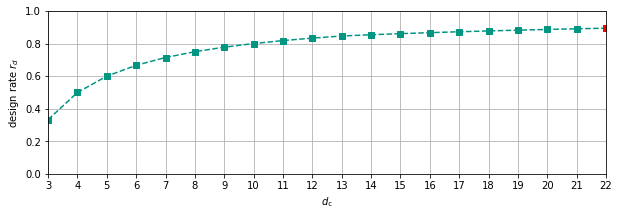

Running optimization for mu_c = 5.00000, corresponding to Es/N0 = 0.97 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.789 for average check node degree of 21.00
Corresponding lambda polynomial
        15          5          2
0.3837 Z  + 0.1962 Z + 0.2455 Z + 0.1745 Z


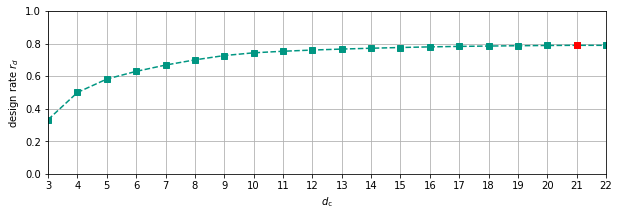

Running optimization for mu_c = 2.50000, corresponding to Es/N0 = -2.04 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.555 for average check node degree of 9.00
Corresponding lambda polynomial
        15        5           4          2
0.3299 Z  + 0.17 Z + 0.03501 Z + 0.2316 Z + 0.2335 Z


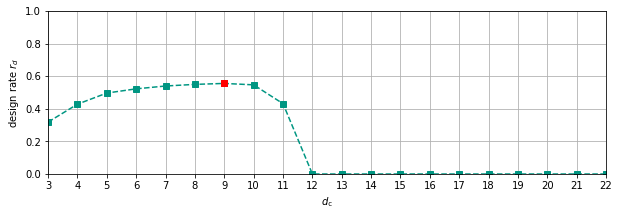

Running optimization for mu_c = 1.25000, corresponding to Es/N0 = -5.05 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.339 for average check node degree of 5.00
Corresponding lambda polynomial
        13           12            6          5          2
0.1339 Z  + 0.06836 Z  + 0.007432 Z + 0.2035 Z + 0.2451 Z + 0.3417 Z


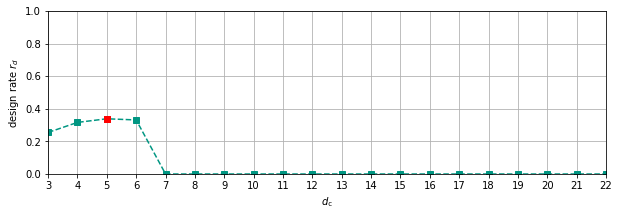

Running optimization for mu_c = 1.87500, corresponding to Es/N0 = -3.29 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.460 for average check node degree of 7.00
Corresponding lambda polynomial
        15          5            4          2
0.2868 Z  + 0.2058 Z + 0.007592 Z + 0.2335 Z + 0.2663 Z


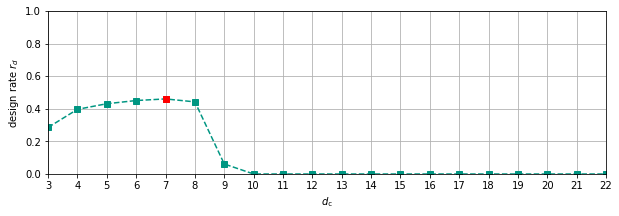

Running optimization for mu_c = 2.18750, corresponding to Es/N0 = -2.62 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.511 for average check node degree of 8.00
Corresponding lambda polynomial
        15          5           4          2
0.3184 Z  + 0.1648 Z + 0.04061 Z + 0.2294 Z + 0.2468 Z


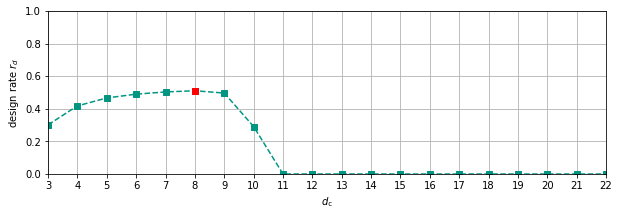

Running optimization for mu_c = 2.03125, corresponding to Es/N0 = -2.94 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.485 for average check node degree of 8.00
Corresponding lambda polynomial
        15          3          2
0.4249 Z  + 0.1833 Z + 0.1544 Z + 0.2374 Z


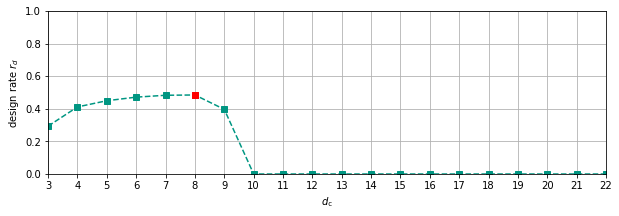

Running optimization for mu_c = 2.10938, corresponding to Es/N0 = -2.78 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.499 for average check node degree of 8.00
Corresponding lambda polynomial
        15          4          2
0.3708 Z  + 0.1796 Z + 0.2075 Z + 0.2421 Z


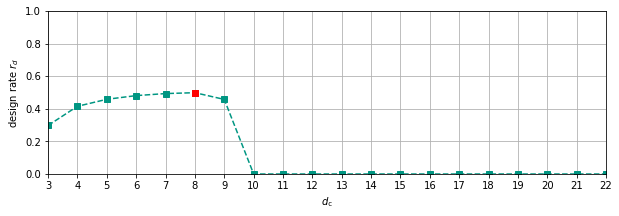

Running optimization for mu_c = 2.14844, corresponding to Es/N0 = -2.70 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.505 for average check node degree of 8.00
Corresponding lambda polynomial
        15           5          4          2
0.3439 Z  + 0.08126 Z + 0.1125 Z + 0.2179 Z + 0.2444 Z


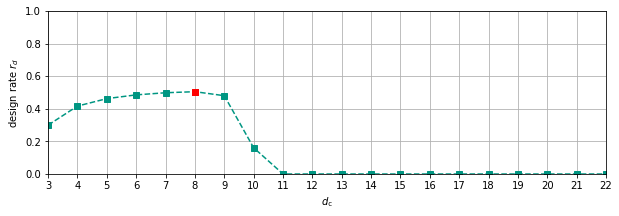

Running optimization for mu_c = 2.12891, corresponding to Es/N0 = -2.74 dB


FloatProgress(value=0.0, max=20.0)

Found best code of rate 0.502 for average check node degree of 8.00
Corresponding lambda polynomial
        15           5          4          2
0.3575 Z  + 0.03598 Z + 0.1514 Z + 0.2118 Z + 0.2432 Z


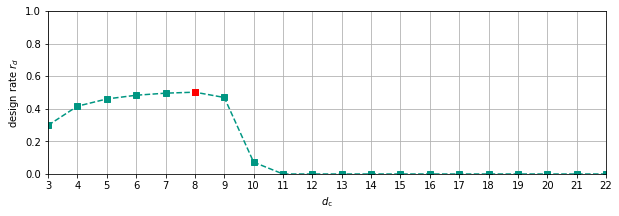

In [121]:
target_rate = 0.7
dv_max = 16
dc_max = 22

T_Delta = 0.01
mu_c = 10
Delta_mu = 10

while Delta_mu >= T_Delta:   
    print('Running optimization for mu_c = %1.5f, corresponding to Es/N0 = %1.2f dB' % (mu_c, 10*np.log10(mu_c/4)))
    
    rate = find_best_rate(mu_c, dv_max, dc_max)
    if rate > target_rate:
        mu_c = mu_c - Delta_mu / 2
    else:
        mu_c = mu_c + Delta_mu / 2
        
    Delta_mu = Delta_mu / 2